In [1]:
import os 
import numpy as np
import re
import matplotlib.pyplot as plt
directory_changed = False 
try:
    from simulations.inhomogeneous import simulate_inhomogeneous_record
except:
    print("Adjusting path for imports..")
    os.chdir("..")
    directory_changed = True
    from simulations.inhomogeneous import simulate_inhomogeneous_record

import results
from src.rq3 import step_inhomogeneous_spatial
from src.rq3 import _compute_cluster_sizes
import data
from concurrent.futures import ProcessPoolExecutor, as_completed
import multiprocessing
import csv
from pathlib import Path
from datetime import datetime
print(os.getcwd())
from scriptss.parallel_sims_rq3 import worker2


Adjusting path for imports..
c:\Users\rorka\PycharmProjects\AIHealth\CSS_project-19


# Simulating different Oak percentages on grid with a Slime distribution

In [2]:
base_dir = Path.cwd() / "data" / "slime_experiment"
base_dir.mkdir(parents=True, exist_ok=True)

# make a new experiment directory
idx = 1
while (base_dir / f"experiment_{idx}").exists():
    idx += 1
outdir = base_dir / f"experiment_{idx}"
outdir.mkdir(parents=True, exist_ok=False)
print(f" Results are stored in: {outdir}")

 Results are stored in: c:\Users\rorka\PycharmProjects\AIHealth\CSS_project-19\data\slime_experiment\experiment_15


In [3]:
# --- PARAMETERS ---
L = 256             # Grid grootte (512 is mooier, 256 is sneller)
p = 0.01            # Groeisnelheid
f = 0.0001          # Bliksemfrequentie
steps = 1000        # Minimaal 5000 voor SOC evenwicht!
runs_per_param = 5  # Aantal runs per oak ratio

# We testen weer dezelfde ratios om te kunnen vergelijken met het random model
oak_ratios = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
p_burn_oak = 0.3    # Eiken branden slecht

# Lijsten bouwen
param_list = []
param_idx = 1
param_map = {} # Handig om straks resultaten terug te vinden

for ratio in oak_ratios:
    param_map[param_idx] = ratio
    
    for run_idx in range(runs_per_param):
        param_list.append({
            'L': L, 'p': p, 'f': f, 'steps': steps,
            'oak_ratio': ratio,      # Dit gaat nu naar de Slime Mold generator
            'p_burn_oak': p_burn_oak,
            'param_id': param_idx,
            'run_id': run_idx
        })
    param_idx += 1

print(f"Ready for {len(param_list)} Slime Mold simulations to run.")
print(f"Variabel Oak Ratios: {oak_ratios}")

Ready for 30 Slime Mold simulations to run.
Variabel Oak Ratios: [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]


In [4]:
max_workers = multiprocessing.cpu_count()
print(f"🚀 Start with {max_workers} Processors...")

results = []
# Hier slaan we de data op per ratio: {0.2: [brand1, brand2...], 0.4: [...]}
fire_data_by_ratio = {ratio: [] for ratio in oak_ratios}

with ProcessPoolExecutor(max_workers=max_workers) as exe:
    # Submit alle taken aan worker2
    futures = {exe.submit(worker2, outdir, params): params for params in param_list}
    
    for fut in as_completed(futures):
        params = futures[fut]
        try:
            res = fut.result()
            
            # Welke ratio was dit?
            pid = params['param_id']
            ratio = param_map[pid]
            
            # Lees de ruwe data in vanuit de CSV die de worker heeft gemaakt
            raw_file = res.get('raw_file')
            if raw_file:
                current_fires = []
                with open(raw_file, 'r') as f:
                    reader = csv.reader(f)
                    next(reader) # Skip header
                    for row in reader:
                        if row: current_fires.append(int(row[0]))
                
                # Voeg toe aan de dataset voor deze ratio
                fire_data_by_ratio[ratio].extend(current_fires)
            
            print(f"✅ Klaar: Slime Mold Ratio {ratio:.1f}, Run {params['run_id']} -> {res['num_fires']} branden")
            results.append(res)
            
        except Exception as e:
            print(f"Error at params {params}: {e}")

print("🏁 All sims Finished")

🚀 Start with 8 Processors...
✅ Klaar: Slime Mold Ratio 0.2, Run 2 -> 3105 branden
✅ Klaar: Slime Mold Ratio 0.0, Run 3 -> 2448 branden
✅ Klaar: Slime Mold Ratio 0.0, Run 2 -> 2503 branden
✅ Klaar: Slime Mold Ratio 0.2, Run 0 -> 3096 branden
✅ Klaar: Slime Mold Ratio 0.2, Run 1 -> 3049 branden
✅ Klaar: Slime Mold Ratio 0.0, Run 0 -> 2458 branden
✅ Klaar: Slime Mold Ratio 0.0, Run 1 -> 2490 branden
✅ Klaar: Slime Mold Ratio 0.0, Run 4 -> 2455 branden
✅ Klaar: Slime Mold Ratio 0.4, Run 1 -> 3824 branden
✅ Klaar: Slime Mold Ratio 0.4, Run 0 -> 3789 branden
✅ Klaar: Slime Mold Ratio 0.4, Run 3 -> 3797 branden
✅ Klaar: Slime Mold Ratio 0.4, Run 4 -> 3767 branden
✅ Klaar: Slime Mold Ratio 0.2, Run 3 -> 3083 branden
✅ Klaar: Slime Mold Ratio 0.6, Run 0 -> 4372 branden
✅ Klaar: Slime Mold Ratio 0.2, Run 4 -> 3108 branden
✅ Klaar: Slime Mold Ratio 0.4, Run 2 -> 3825 branden
✅ Klaar: Slime Mold Ratio 0.6, Run 3 -> 4468 branden
✅ Klaar: Slime Mold Ratio 0.8, Run 0 -> 5242 branden
✅ Klaar: Slime Mo

--- START DEBUG PLOT ---
Ratio 0.0: Totaal 12354 items. Na filter (>0): 12354 items.
   Min grootte: 1, Max grootte: 3935
Ratio 0.2: Totaal 15441 items. Na filter (>0): 11724 items.
   Min grootte: 1, Max grootte: 3091
Ratio 0.4: Totaal 19002 items. Na filter (>0): 11259 items.
   Min grootte: 1, Max grootte: 2641
Ratio 0.6: Totaal 22344 items. Na filter (>0): 10307 items.
   Min grootte: 1, Max grootte: 2639
Ratio 0.8: Totaal 25821 items. Na filter (>0): 9778 items.
   Min grootte: 1, Max grootte: 1391
Ratio 1.0: Totaal 28797 items. Na filter (>0): 8744 items.
   Min grootte: 1, Max grootte: 74


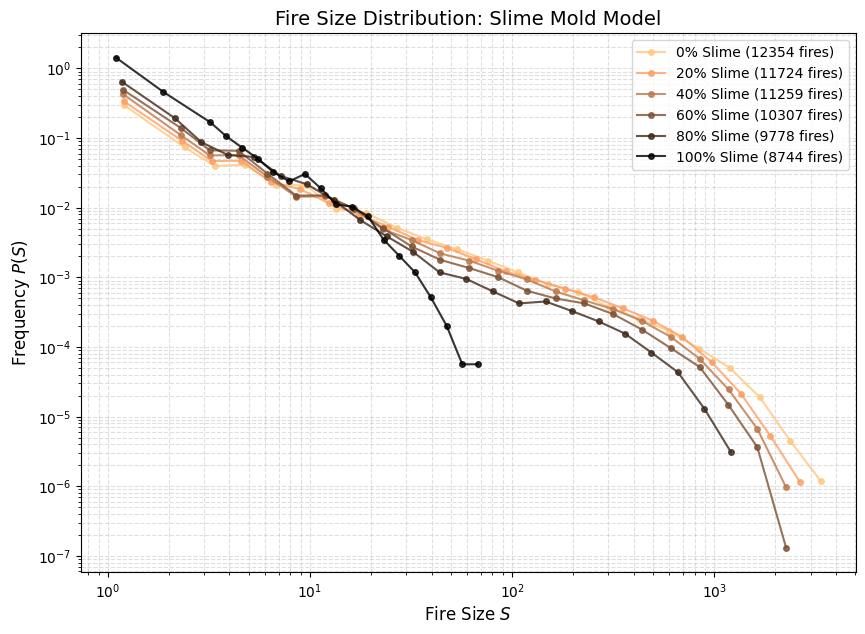

Plot opgeslagen in: results/RQ3\LogLogSlimeDistribution.png


In [6]:
import matplotlib.pyplot as plt
import numpy as np
import os

# 1. Output map
output_dir = "results/RQ3"
os.makedirs(output_dir, exist_ok=True)

plt.figure(figsize=(10, 7))
colors = plt.cm.copper(np.linspace(1, 0, len(fire_data_by_ratio)))

print("--- START DEBUG PLOT ---")

# 2. Loop
for idx, (ratio, fires) in enumerate(sorted(fire_data_by_ratio.items())):
    
    # STAP A: Converteer expliciet naar getallen (voorkomt string-fouten)
    # We gebruiken dtype=float om crashes te voorkomen, daarna int
    try:
        data = np.array(fires, dtype=float).astype(int)
    except Exception as e:
        print(f"❌ Ratio {ratio}: Kon data niet omzetten naar nummers. Fout: {e}")
        continue

    total_count = len(data)
    
    # STAP B: Filteren
    # We kijken wat er overblijft na filteren
    data_filtered = data[data > 0]
    filtered_count = len(data_filtered)
    
    print(f"Ratio {ratio:.1f}: Totaal {total_count} items. Na filter (>0): {filtered_count} items.")
    
    if filtered_count == 0:
        print(f"   ⚠️ WAARSCHUWING: Alle branden zijn grootte 0! Sla deze over.")
        # Print een voorbeeldje om te zien wat er in zit
        print(f"   Voorbeeld data (eerste 10): {fires[:10]}")
        continue
        
    # STAP C: Check Min/Max
    min_val = data_filtered.min()
    max_val = data_filtered.max()
    print(f"   Min grootte: {min_val}, Max grootte: {max_val}")

    if min_val == max_val:
        print("   ⚠️ WAARSCHUWING: Min en Max zijn gelijk (alle branden even groot). Kan geen log-lijn maken.")
        continue

    # STAP D: Bins maken
    min_pow = np.log10(min_val)
    max_pow = np.log10(max_val)
    bins = np.logspace(min_pow, max_pow, num=25)
    
    hist, edges = np.histogram(data_filtered, bins=bins, density=True)
    centers = (edges[:-1] + edges[1:]) / 2
    
    mask = hist > 0
    
    label_text = f"{int(ratio*100)}% Slime ({filtered_count} fires)"
    plt.loglog(centers[mask], hist[mask], marker='o', linestyle='-', 
               linewidth=1.5, markersize=4, color=colors[idx], 
               label=label_text, alpha=0.8)

# 3. Opmaak
plt.title(f"Fire Size Distribution: Slime Mold Model", fontsize=14)
plt.xlabel("Fire Size $S$", fontsize=12)
plt.ylabel("Frequency $P(S)$", fontsize=12)
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.4)

save_path = os.path.join(output_dir, "LogLogSlimeDistribution.png")
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"Plot opgeslagen in: {save_path}")

Even geduld, slime mold is aan het tekenen...
✅ Plaatje opgeslagen in: results/RQ3\slime_mold_trails_heatmap.png


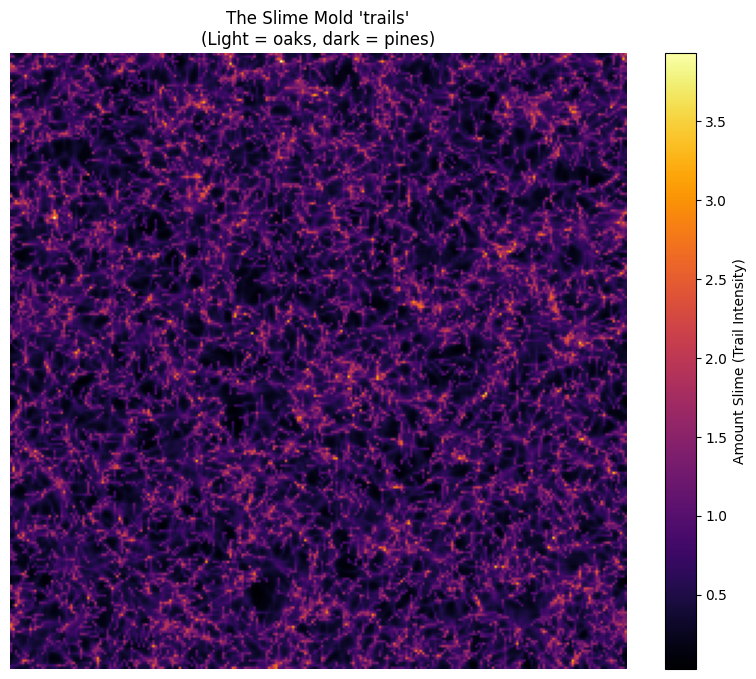

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import os  # <--- Nodig voor mappen maken

def get_trails_for_plotting(L, ratio, steps=400):
    # 1. Instellingen
    num_agents = int(L * L * 0.08) 
    agents_x = np.random.rand(num_agents) * L
    agents_y = np.random.rand(num_agents) * L
    agents_angle = np.random.rand(num_agents) * 2 * np.pi
    trail_map = np.zeros((L, L))
    
    for _ in range(steps):
        # Move
        agents_x += np.cos(agents_angle)
        agents_y += np.sin(agents_angle)
        agents_x %= L
        agents_y %= L
        
        # Deposit
        ix = agents_x.astype(int)
        iy = agents_y.astype(int)
        np.add.at(trail_map, (ix, iy), 1.0)
        
        # Diffuse & Decay
        trail_map = gaussian_filter(trail_map, sigma=0.4) * 0.90
        
        # Sense
        agents_angle += (np.random.rand(num_agents) - 0.5) * 0.5

    return trail_map

print("Even geduld, slime mold is aan het tekenen...")

L_plot = 256
trails = get_trails_for_plotting(L=L_plot, ratio=0.4) # Ratio wordt hier niet gebruikt voor threshold, puur voor de run

# --- HET PLOTTEN EN OPSLAAN ---
# 1. Map aanmaken
output_dir = "results/RQ3"
os.makedirs(output_dir, exist_ok=True)

plt.figure(figsize=(10, 8))
plt.imshow(trails, cmap='inferno') 
plt.colorbar(label="Amount Slime (Trail Intensity)")
plt.title("The Slime Mold 'trails'\n(Light = oaks, dark = pines)")
plt.axis('off')

# 2. Opslaan (doe dit VOOR plt.show!)
save_path = os.path.join(output_dir, "slime_mold_trails_heatmap.png")
plt.savefig(save_path, dpi=300, bbox_inches='tight')

print(f"✅ Plaatje opgeslagen in: {save_path}")

# 3. Laten zien
plt.show()

Genereren van kaarten met 40% Eiken...
✅ Vergelijking opgeslagen in: results/RQ3\spatial_comparison_random_vs_slime.png


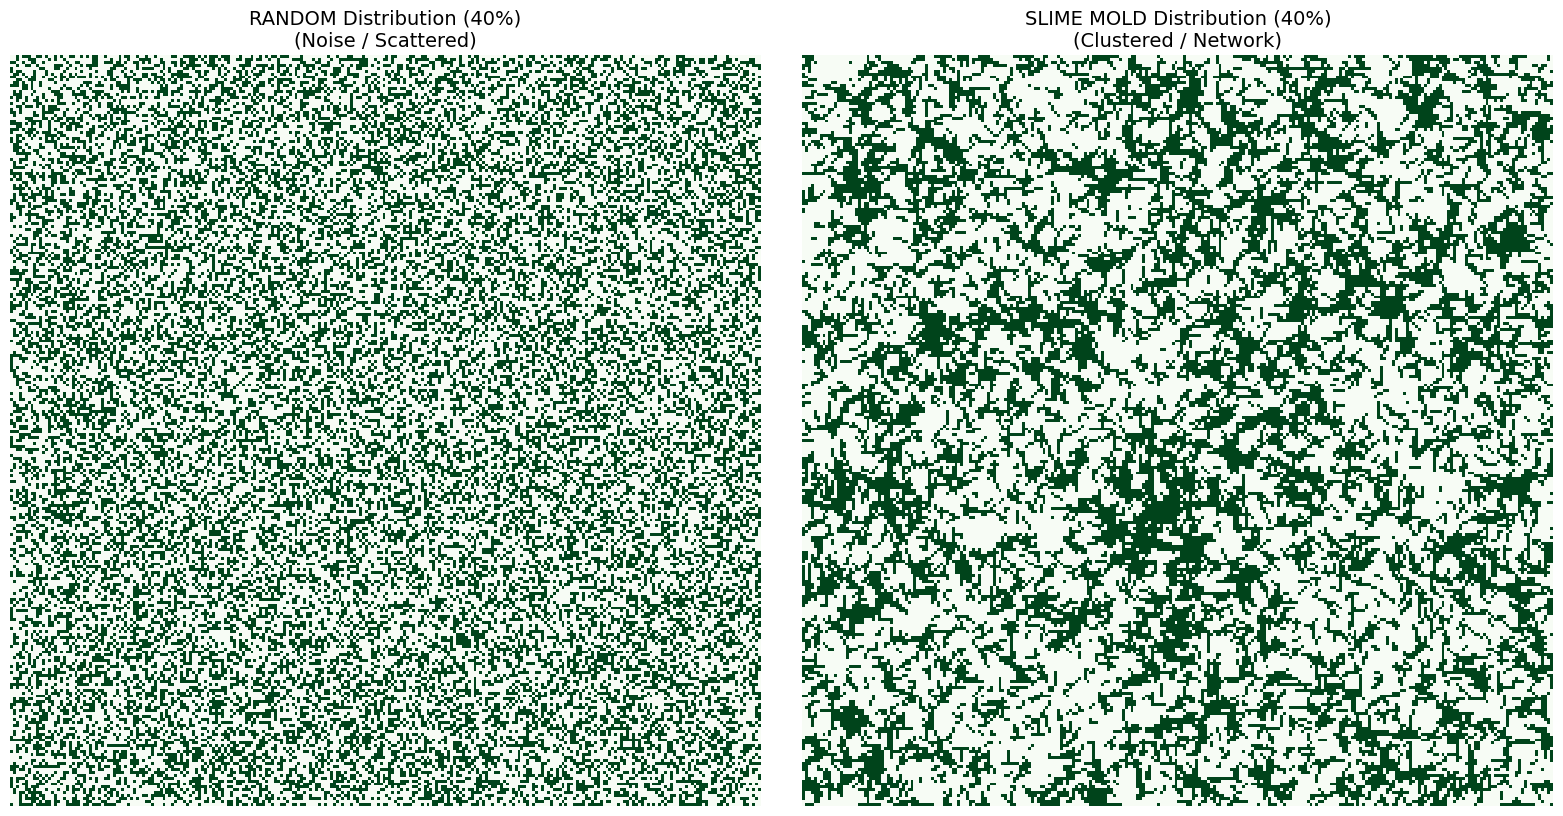

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import os

# 1. De Functie voor Slime Mold
def get_slime_mask(L, ratio, steps=400):
    num_agents = int(L * L * 0.08) 
    agents_x = np.random.rand(num_agents) * L
    agents_y = np.random.rand(num_agents) * L
    agents_angle = np.random.rand(num_agents) * 2 * np.pi
    trail_map = np.zeros((L, L))
    
    for _ in range(steps):
        agents_x += np.cos(agents_angle); agents_y += np.sin(agents_angle)
        agents_x %= L; agents_y %= L
        np.add.at(trail_map, (agents_x.astype(int), agents_y.astype(int)), 1.0)
        trail_map = gaussian_filter(trail_map, sigma=0.4) * 0.90 
        agents_angle += (np.random.rand(num_agents) - 0.5) * 0.5
        
    threshold = np.percentile(trail_map.flatten(), 100 - (ratio * 100))
    return trail_map > threshold

# 2. De Functie voor Random
def get_random_mask(L, ratio):
    random_noise = np.random.rand(L, L)
    return random_noise < ratio

# --- DE VERGELIJKING PLOTTEN EN OPSLAAN ---

# Map aanmaken
output_dir = "results/RQ3"
os.makedirs(output_dir, exist_ok=True)

L_plot = 256
ratio_plot = 0.4 

print(f"Genereren van kaarten met {int(ratio_plot*100)}% Eiken...")

mask_slime = get_slime_mask(L_plot, ratio_plot)
mask_random = get_random_mask(L_plot, ratio_plot)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Random Links
axes[0].imshow(mask_random, cmap='Greens', interpolation='nearest')
axes[0].set_title(f"RANDOM Distribution ({int(ratio_plot*100)}%)\n(Noise / Scattered)", fontsize=14)
axes[0].axis('off')

# Slime Rechts
axes[1].imshow(mask_slime, cmap='Greens', interpolation='nearest')
axes[1].set_title(f"SLIME MOLD Distribution ({int(ratio_plot*100)}%)\n(Clustered / Network)", fontsize=14)
axes[1].axis('off')

plt.tight_layout()

# --- OPSLAAN ---
save_path = os.path.join(output_dir, "spatial_comparison_random_vs_slime.png")
plt.savefig(save_path, dpi=300, bbox_inches='tight')

print(f"✅ Vergelijking opgeslagen in: {save_path}")

plt.show()

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import csv
from scipy.stats import ks_2samp

# --- 1. INSTELLINGEN ---
# De mappen die je net doorgaf:
folder_random = "data/inhomogeneous_experiment/experiment_7"
folder_slime  = "data/slime_experiment/experiment_15"

# Welke density wil je vergelijken? (0.4 laat vaak het grootste verschil zien)
target_ratio = 0.4 
search_term = f"ratio{target_ratio}" # Zoekt naar bijv. 'ratio0.4' in bestandsnaam

# Map voor het opslaan van de vergelijkingsplot
output_dir = "results/Comparison"
os.makedirs(output_dir, exist_ok=True)

# --- 2. FUNCTIE OM DATA TE LADEN ---
def load_data(folder_path, term):
    fire_sizes = []
    # Zoek alle .csv bestanden in de map
    search_pattern = os.path.join(folder_path, "*.csv")
    files = glob.glob(search_pattern)
    
    print(f"📂 Zoeken in '{folder_path}' naar '{term}'...")
    found_files = 0
    
    for filename in files:
        # Check of de bestandsnaam overeenkomt met de target ratio
        if term in filename:
            found_files += 1
            try:
                with open(filename, 'r') as f:
                    reader = csv.reader(f)
                    # Probeer header te skippen als die er is
                    header = next(reader, None)
                    
                    # Lees de regels
                    for row in reader:
                        if row:
                            try:
                                val = int(float(row[0])) # float->int voor veiligheid
                                fire_sizes.append(val)
                            except ValueError:
                                continue
            except Exception as e:
                print(f"   ⚠️ Fout bij lezen {filename}: {e}")

    print(f"   👉 {found_files} bestanden gevonden. Totaal {len(fire_sizes)} branden ingeladen.")
    return np.array(fire_sizes)

# --- 3. DATA OPHALEN & FILTEREN ---
print("--- START DATA LOADING ---")
data_random = load_data(folder_random, search_term)
data_slime  = load_data(folder_slime, search_term)

# Filter 0 en hele kleine brandjes (ruis) weg
data_random = data_random[data_random > 0]
data_slime  = data_slime[data_slime > 0]

# Check of we genoeg data hebben
if len(data_random) == 0 or len(data_slime) == 0:
    print("\n❌ HELAAS: Eén van de datasets is leeg. Check of 'target_ratio' klopt met je bestandsnamen.")
else:
    # --- 4. DE STATISTIEK (KS-TEST) ---
    statistic, p_value = ks_2samp(data_random, data_slime)

    print(f"\n--- Resultaten voor {target_ratio*100}% Oaks ---")
    print(f"📊 Kolmogorov-Smirnov Statistic: {statistic:.5f}")
    print(f"📉 P-value: {p_value}") 
    
    if p_value < 0.05:
        print("✅ CONCLUSIE: Het verschil is STATISTISCH SIGNIFICANT (p < 0.05).")
        print("   Dit betekent dat de Slime Mold structuur écht effect heeft op de brandgrootte.")
    else:
        print("⚠️ CONCLUSIE: Geen significant verschil gevonden.")

    # --- 5. DE PLOT (LOG-LOG) ---
    plt.figure(figsize=(10, 7))

    # Helper voor bins
    def get_bins(data):
        min_p = np.log10(min(data))
        max_p = np.log10(max(data))
        return np.logspace(min_p, max_p, 30)

    # Plot Random
    bins_rnd = get_bins(data_random)
    hist_rnd, edges_rnd = np.histogram(data_random, bins=bins_rnd, density=True)
    centers_rnd = (edges_rnd[:-1] + edges_rnd[1:]) / 2
    mask_rnd = hist_rnd > 0
    plt.loglog(centers_rnd[mask_rnd], hist_rnd[mask_rnd], 'o-', 
               color='blue', label=f'Random ({int(target_ratio*100)}%)', alpha=0.6, markersize=4)

    # Plot Slime
    bins_slm = get_bins(data_slime)
    hist_slm, edges_slm = np.histogram(data_slime, bins=bins_slm, density=True)
    centers_slm = (edges_slm[:-1] + edges_slm[1:]) / 2
    mask_slm = hist_slm > 0
    plt.loglog(centers_slm[mask_slm], hist_slm[mask_slm], 'o-', 
               color='red', label=f'Slime Mold ({int(target_ratio*100)}%)', alpha=0.6, markersize=4)

    plt.title(f"Fire Size Distribution Comparison (Density {target_ratio})", fontsize=14)
    plt.xlabel("Fire Size $S$ (number of trees)", fontsize=12)
    plt.ylabel("Frequency $P(S)$", fontsize=12)
    plt.legend()
    plt.grid(True, which="both", ls="--", alpha=0.3)
    
    # Opslaan
    save_filename = f"comparison_random_vs_slime_{target_ratio}.png"
    save_path = os.path.join(output_dir, save_filename)
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    print(f"\n🖼️ Plot opgeslagen als: {save_path}")
    plt.show()

--- START DATA LOADING ---
📂 Zoeken in 'data/inhomogeneous_experiment/experiment_7' naar 'ratio0.4'...
   👉 0 bestanden gevonden. Totaal 0 branden ingeladen.
📂 Zoeken in 'data/slime_experiment/experiment_15' naar 'ratio0.4'...
   👉 0 bestanden gevonden. Totaal 0 branden ingeladen.

❌ HELAAS: Eén van de datasets is leeg. Check of 'target_ratio' klopt met je bestandsnamen.


In [12]:
import os

# De mappen waar we in gaan kijken
paths_to_check = [
    "data/inhomogeneous_experiment/experiment_7",
    "data/slime_experiment/experiment_15"
]

print("--- 🕵️ BESTANDS-INSPECTIE ---")

for folder in paths_to_check:
    print(f"\n📂 Map: {folder}")
    
    # 1. Bestaat de map überhaupt?
    if not os.path.exists(folder):
        print(f"   ❌ ERROR: Deze map bestaat niet! Check je pad.")
        # Tip: Misschien zit je in src/ en moet je ../data doen?
        print(f"   (Je huidige werkmap is: {os.getcwd()})")
        continue

    # 2. Wat zit erin?
    files = os.listdir(folder)
    csv_files = [f for f in files if f.endswith('.csv')]
    
    if len(csv_files) == 0:
        print("   ⚠️ Wel map gevonden, maar GEEN .csv bestanden.")
    else:
        print(f"   ✅ {len(csv_files)} CSV-bestanden gevonden.")
        print(f"   Voorbeeldnamen (eerste 3):")
        for name in csv_files[:3]:
            print(f"     - {name}")

--- 🕵️ BESTANDS-INSPECTIE ---

📂 Map: data/inhomogeneous_experiment/experiment_7
   ✅ 60 CSV-bestanden gevonden.
   Voorbeeldnamen (eerste 3):
     - fires_param1_oak0.0_id0_20260130T085830Z.csv
     - fires_param1_oak0.0_id1_20260130T085835Z.csv
     - fires_param1_oak0.0_id2_20260130T085831Z.csv

📂 Map: data/slime_experiment/experiment_15
   ✅ 30 CSV-bestanden gevonden.
   Voorbeeldnamen (eerste 3):
     - fires_spatial_p1_r0.csv
     - fires_spatial_p1_r1.csv
     - fires_spatial_p1_r2.csv


🔎 Strategie: Random zoeken op 'oak0.4', Slime zoeken op '_p3_'
   📂 Map: ...eriment/experiment_7 | Term: 'oak0.4' | Files: 10 | Data: 25211
   📂 Map: ...riment/experiment_15 | Term: '_p3_' | Files: 5 | Data: 19002

RESULTATEN (Ratio 0.4)
KS Statistic: 0.13388
P-value:      4.132893937811813e-122
✅ SIGNIFICANT VERSCHIL! (p < 0.05)

🖼️ Plot opgeslagen: results/Comparison\COMPARE_final_0.4.png


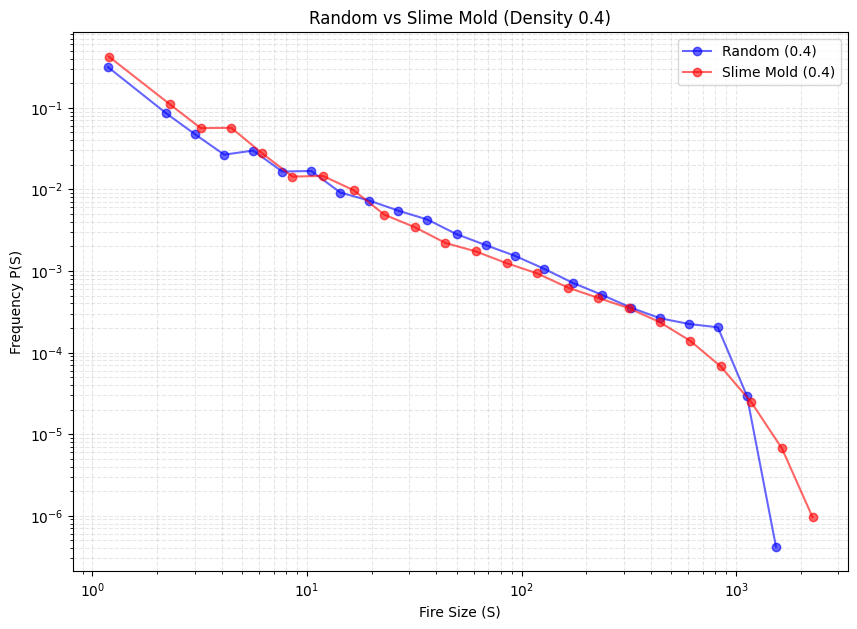

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import csv
from scipy.stats import ks_2samp

# --- 1. INSTELLINGEN ---
folder_random = "data/inhomogeneous_experiment/experiment_7"
folder_slime  = "data/slime_experiment/experiment_15"

target_ratio = 0.4  # We willen 40% vergelijken

# We moeten even terugrekenen welke 'p' code bij 0.4 hoort voor de Slime files
# Dit is de volgorde die je in je simulatie gebruikte:
ratios_list = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

try:
    # +1 omdat param_id meestal bij 1 begint, niet 0
    slime_param_id = ratios_list.index(target_ratio) + 1 
except ValueError:
    print("⚠️ Target ratio staat niet in de standaard lijst!")
    slime_param_id = 3 # Gokje (p3 is vaak 0.4)

# De zoektermen bepalen
# Voor Random zoeken we naar "oak0.4"
search_random = f"oak{target_ratio}"
# Voor Slime zoeken we naar "_p3_" (met underscores om p13 te voorkomen)
search_slime  = f"_p{slime_param_id}_"

print(f"🔎 Strategie: Random zoeken op '{search_random}', Slime zoeken op '{search_slime}'")

# Output map
output_dir = "results/Comparison"
os.makedirs(output_dir, exist_ok=True)


# --- 2. FUNCTIE OM DATA TE LADEN ---
def load_data_flexible(folder_path, search_string):
    fire_sizes = []
    files = glob.glob(os.path.join(folder_path, "*.csv"))
    
    found_count = 0
    for filename in files:
        if search_string in filename:
            found_count += 1
            try:
                with open(filename, 'r') as f:
                    reader = csv.reader(f)
                    header = next(reader, None) # Skip header "fire_size"
                    
                    for row in reader:
                        if row:
                            # Soms staat er rommel in, veilig omzetten
                            try:
                                val = float(row[0])
                                fire_sizes.append(int(val))
                            except:
                                continue
            except Exception as e:
                print(f"Error reading {filename}: {e}")
                
    print(f"   📂 Map: ...{folder_path[-20:]} | Term: '{search_string}' | Files: {found_count} | Data: {len(fire_sizes)}")
    return np.array(fire_sizes)

# --- 3. UITVOEREN ---
data_random = load_data_flexible(folder_random, search_random)
data_slime  = load_data_flexible(folder_slime, search_slime)

# Filter 0 en hele kleine brandjes
data_random = data_random[data_random > 0]
data_slime  = data_slime[data_slime > 0]

if len(data_random) == 0 or len(data_slime) == 0:
    print("\n❌ NOG STEEDS 0 DATA. Check de zoektermen hierboven!")
else:
    # --- 4. STATISTIEK (KS-TEST) ---
    statistic, p_value = ks_2samp(data_random, data_slime)
    
    print("\n" + "="*40)
    print(f"RESULTATEN (Ratio {target_ratio})")
    print("="*40)
    print(f"KS Statistic: {statistic:.5f}")
    print(f"P-value:      {p_value}")
    
    if p_value < 0.05:
        print("✅ SIGNIFICANT VERSCHIL! (p < 0.05)")
    else:
        print("❌ Geen significant verschil.")

    # --- 5. DE PLOT ---
    plt.figure(figsize=(10, 7))

    def get_bins(data):
        return np.logspace(np.log10(min(data)), np.log10(max(data)), 25)

    # Random (Blauw)
    bins1 = get_bins(data_random)
    hist1, edges1 = np.histogram(data_random, bins=bins1, density=True)
    centers1 = (edges1[:-1] + edges1[1:]) / 2
    plt.loglog(centers1[hist1>0], hist1[hist1>0], 'o-', label=f'Random ({target_ratio})', color='blue', alpha=0.6)

    # Slime (Rood)
    bins2 = get_bins(data_slime)
    hist2, edges2 = np.histogram(data_slime, bins=bins2, density=True)
    centers2 = (edges2[:-1] + edges2[1:]) / 2
    plt.loglog(centers2[hist2>0], hist2[hist2>0], 'o-', label=f'Slime Mold ({target_ratio})', color='red', alpha=0.6)

    plt.title(f"Random vs Slime Mold (Density {target_ratio})")
    plt.xlabel("Fire Size (S)")
    plt.ylabel("Frequency P(S)")
    plt.legend()
    plt.grid(True, which="both", ls="--", alpha=0.3)
    
    save_path = os.path.join(output_dir, f"COMPARE_final_{target_ratio}.png")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"\n🖼️ Plot opgeslagen: {save_path}")
    plt.show()